In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from collections import deque
import matplotlib.pyplot as plt
from Grouping import *
import warnings
warnings.filterwarnings(action='ignore')

# Integration

In [2]:
def Comp(M, N, num_of_video, num_of_client, cache_size, s_len, l_len, K, zipf_param):
    def zipf(VN, P, n):
        return np.random.choice(VN, n, False, P)
    
    def cal_con(rqs, caches, r = 0, X = 0):
        cn, rq, ch = Local(rqs, caches)
        cn, rq, ch = BCG(list(range(num_of_video)), cn, rq, ch)
        if X:
            con = len(cn)
        cn, rq, ch = XBCG(list(range(num_of_video)), cn, rq, ch)
        xcon = len(cn)
        if r:
            reward = np.zeros(num_of_client)
            local = np.ones(num_of_client)
            for c in cn:
                if len(c) > 1:
                    for i in c:
                        reward[i] = 0.5
                        local[i] = 0
                else:
                    local[c[0]] = 0
            reward = reward + local
        if X:
            return xcon, con
        else:
            if r:
                return xcon, reward
            else:
                return xcon

    class A2C_Agent:
        def __init__(self, state_size, action_size, batch_size):
            global advantages
            self.state_size = state_size
            self.action_size = action_size
            self.value_size = 1
            self.batch_size = batch_size
            advantages = np.zeros((self.batch_size, self.action_size))

            self.discount_factor = 0.9
            self.actor_lr = 0.001
            self.critic_lr = 0.01

            self.main_actor = self.build_actor()
            self.main_critic = self.build_critic()
            self.target_critic = self.build_critic()
            self.target_critic.set_weights(self.main_critic.get_weights())

        def score_func_loss(self, Y, action_pred):
            global advantages
            log_lik = -Y * tf.math.log(action_pred)
            log_lik_adv = log_lik * advantages
            loss = tf.reduce_mean(tf.reduce_sum(log_lik_adv, axis=1))
            return loss

        def build_actor(self):
            actor = tf.keras.models.Sequential()
            actor.add(Dense(self.state_size*2, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
            actor.add(Dense(self.action_size, activation='softmax',kernel_initializer='he_uniform'))
            actor.compile(loss=self.score_func_loss, optimizer=tf.keras.optimizers.Adam(lr=self.actor_lr))
            return actor

        def build_critic(self):
            critic = tf.keras.models.Sequential()
            critic.add(Dense(self.state_size*2, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
            critic.add(Dense(self.value_size, activation='linear',kernel_initializer='he_uniform'))
            critic.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=self.critic_lr))
            return critic

        def train_model(self, state_batch, reward_batch, target_train):
            global advantages
            states = np.vstack([x[0] for x in state_batch])
            actions = np.array([x[1] for x in state_batch])
            next_states = np.vstack([x[2] for x in state_batch])
            rewards = np.vstack([x for x in reward_batch])

            target = np.zeros((self.batch_size, self.value_size))
            advantages = np.zeros((self.batch_size, self.action_size))

            value = self.main_critic.predict(states)
            next_value = self.target_critic.predict(next_states)

            target = rewards + self.discount_factor * next_value
            advantages[range(self.batch_size), actions] = np.reshape(target - value, self.batch_size)

            self.main_actor.fit(states, advantages, epochs=1, verbose=0)
            self.main_critic.fit(states, target, epochs=1, verbose=0)

            if target_train:
                self.target_critic.set_weights(self.main_critic.get_weights())

    class cache_env:
        def __init__(self, VN, cs, s_len, l_len, K, a=1):
            self.VN = VN
            self.cs = cs
            self.K = K
            self.s_len = s_len
            self.l_len = l_len
            self.s_buffer = []
            self.l_buffer = []
            self.s_cnt = np.zeros(VN)
            self.l_cnt = np.zeros(VN)
            self.a = a
            self.P = np.array([1/(i**self.a) for i in range(1, self.VN+1)])
            self.P /= sum(self.P)
            np.random.shuffle(self.P)
            self.AC_state = []
            self.FIFO_state = []
            self.LFU_state = []
            self.LRU_state = []
            self.rq = zipf(self.VN, self.P, 1)
            self.LFU_count = np.zeros(self.VN)
            self.count()

        def step(self, a):
            self.LFU_count[self.rq[0]] += 1
            rq = list(self.rq)
            prev_state = np.hstack((self.s_cnt[rq + self.AC_state], self.l_cnt[rq + self.AC_state]))
            states = None
            if a == 'pass':
                pass
            elif a == 'append':
                self.AC_state.append(self.rq[0])
            else:
                states = [copy.deepcopy(self.AC_state) for _ in range(K)]
                for i in range(K):
                    if a[i] == 0:
                        continue
                    states[i].remove(states[i][a[i]-1])
                    states[i].append(self.rq[0])
            self.FIFO()
            self.LFU()
            self.LRU()
            self.rq = zipf(self.VN, self.P, 1)
            self.count()
            return prev_state, states
        
        def count(self):
            if sum(self.s_cnt) == self.s_len:
                self.s_cnt[self.s_buffer[0]] -= 1
                self.s_buffer = self.s_buffer[1:]
            self.s_cnt[self.rq] += 1
            self.s_buffer.append(self.rq[0])
            if sum(self.l_cnt) == self.l_len:
                self.l_cnt[self.l_buffer[0]] -= 1
                self.l_buffer = self.l_buffer[1:]
            self.l_cnt[self.rq] += 1
            self.l_buffer.append(self.rq[0])
        
        def FIFO(self):
            if self.rq[0] not in self.FIFO_state:
                if len(self.FIFO_state) < self.cs:
                    self.FIFO_state.append(self.rq[0])
                else:
                    self.FIFO_state = self.FIFO_state[1:] + list(self.rq)
            
        def LFU(self):
            if self.rq[0] not in self.LFU_state:
                if len(self.LFU_state) < self.cs:
                    self.LFU_state.append(self.rq[0])
                else:
                    count_l = self.LFU_count[np.array(self.LFU_state)]
                    idx = np.where(np.array(count_l) == min(count_l))[0][0]
                    self.LFU_state.remove(self.LFU_state[idx])
                    self.LFU_state.append(self.rq[0])
            
        def LRU(self):
            if self.rq[0] in self.LRU_state:
                self.LRU_state.remove(self.rq[0])
                self.LRU_state.append(self.rq[0])
            else:
                if len(self.LRU_state) < self.cs:
                    self.LRU_state.append(self.rq[0])
                else:
                    self.LRU_state = self.LRU_state[1:] + list(self.rq)

    state_size = 2 * (cache_size + 1)
    action_size = cache_size + 1
    target_update_fre = 10
    
    memory_size = 50
    state_memory = [deque(maxlen = memory_size) for _ in range(num_of_client)]
    reward_memory = [deque(maxlen = memory_size) for _ in range(num_of_client)]
    batch_size = 10

    with tf.Graph().as_default():
        Agents = [A2C_Agent(state_size, action_size, batch_size) for _ in range(num_of_client)]
        cache = [cache_env(num_of_video, cache_size, s_len, l_len, K, zipf_param) for _ in range(num_of_client)]
        count = 0
        AC_c, FIFO_c, LFU_c, LRU_c = 0, 0, 0, 0
        FIFO_xc, LFU_xc, LRU_xc = 0, 0, 0
        AC_con, FIFO_con, LFU_con, LRU_con = [], [], [], []
        FIFO_xcon, LFU_xcon, LRU_xcon = [], [], []
        for i in range(N):
            e = 1 / ((i/10)+1)
            Train = np.zeros(num_of_client)
            for n in range(num_of_client):
                if np.random.rand() < ch_p:
                    new_P = np.array([1/(i**cache[n].a) for i in range(1, cache[n].VN+1)])
                    new_P /= sum(new_P)
                    np.random.shuffle(new_P)
                    cache[n].P = rho * cache[n].P + (1-rho) * new_P
                    
                if cache[n].rq in cache[n].AC_state:
                    prev_state = cache[n].step('pass')
                elif len(cache[n].AC_state) < cache[n].cs:
                    prev_state = cache[n].step('append')
                else:
                    Train[n] = 1
                    rq = list(cache[n].rq)
                    state = np.hstack((cache[n].s_cnt[rq + cache[n].AC_state], cache[n].l_cnt[rq + cache[n].AC_state]))

                    pred = Agents[n].main_actor.predict(np.array([state]))[0]
                    a_list = np.random.choice(action_size, K, False, p = pred)

                    prev_state, states = cache[n].step(a_list)
                    rq = list(cache[n].rq)
                    state_list = [np.hstack((cache[n].s_cnt[rq + states[i]], cache[n].l_cnt[rq + states[i]])) for i in range(K)]
                    critics = Agents[n].main_critic.predict(np.vstack(state_list))
                    idx = np.where(critics == max(critics))[0][0]
                    a = a_list[idx]
                    cache[n].AC_state = states[idx]
                    
                    state = state_list[idx]
                    state_memory[n].append((prev_state, a, state))

            count += num_of_client
            
            rqs = np.array([cache[i].rq for i in range(num_of_client)])
            caches = [cache[i].AC_state for i in range(num_of_client)]
            connection, reward = cal_con(rqs, caches, r=1)
            AC_c += connection
            AC_con.append(AC_c / count)
            
            caches = [cache[i].FIFO_state for i in range(num_of_client)]
            Xconnection, connection = cal_con(rqs, caches, X=1)
            FIFO_c += connection
            FIFO_xc += Xconnection
            FIFO_con.append(FIFO_c / count)
            FIFO_xcon.append(FIFO_xc / count)
            
            caches = [cache[i].LFU_state for i in range(num_of_client)]
            Xconnection, connection = cal_con(rqs, caches, X=1)
            LFU_c += connection
            LFU_xc += Xconnection
            LFU_con.append(LFU_c / count)
            LFU_xcon.append(LFU_xc / count)
            
            caches = [cache[i].LRU_state for i in range(num_of_client)]
            Xconnection, connection = cal_con(rqs, caches, X=1)
            LRU_c += connection
            LRU_xc += Xconnection
            LRU_con.append(LRU_c / count)
            LRU_xcon.append(LRU_xc / count)

            for n in range(num_of_client):
                if Train[n]:
                    reward_memory[n].append(reward[n])
                    if len(reward_memory[n]) >= batch_size:
                        batch = np.random.choice(len(reward_memory[n]), min(len(reward_memory[n]), batch_size), False)
                        state_batch = np.array(state_memory[n])[batch]
                        reward_batch = np.array(reward_memory[n])[batch]
                        Agents[n].train_model(state_batch, reward_batch, (i+1) % target_update_fre == 0)

        count = 0
        AC_tc, FIFO_tc, LFU_tc, LRU_tc = 0, 0, 0, 0
        FIFO_txc, LFU_txc, LRU_txc = 0, 0, 0
        AC_tcon, FIFO_tcon, LFU_tcon, LRU_tcon = [], [], [], []
        FIFO_txcon, LFU_txcon, LRU_txcon = [], [], []
        for i in range(test_N):
            for n in range(num_of_client):
                if np.random.rand() < ch_p:
                    new_P = np.array([1/(i**cache[n].a) for i in range(1, cache[n].VN+1)])
                    new_P /= sum(new_P)
                    np.random.shuffle(new_P)
                    cache[n].P = rho * cache[n].P + (1-rho) * new_P
                
                if cache[n].rq in cache[n].AC_state:
                    cache[n].step('pass')
                else:
                    rq = list(cache[n].rq)
                    state = np.hstack((cache[n].s_cnt[rq + cache[n].AC_state], cache[n].l_cnt[rq + cache[n].AC_state]))
                    
                    pred = Agents[n].main_actor.predict(np.array([state]))[0]
                    a_list = np.random.choice(action_size, K, False, p = pred)

                    _, states = cache[n].step(a_list)
                    rq = list(cache[n].rq)
                    state_list = [np.hstack((cache[n].s_cnt[rq + states[i]], cache[n].l_cnt[rq + states[i]]))  for i in range(K)]
                    critics = Agents[n].main_critic.predict(np.vstack(state_list))
                    idx = np.where(critics == max(critics))[0][0]
                    a = a_list[idx]
                    cache[n].AC_state = states[idx]

            count += num_of_client
            
            rqs = np.array([cache[i].rq for i in range(num_of_client)])
            caches = [cache[i].AC_state for i in range(num_of_client)]
            connection = cal_con(rqs, caches)
            AC_tc += connection
            AC_tcon.append(AC_tc / count)
            
            caches = [cache[i].FIFO_state for i in range(num_of_client)]
            Xconnection, connection = cal_con(rqs, caches, X=1)
            FIFO_tc += connection
            FIFO_txc += Xconnection
            FIFO_tcon.append(FIFO_tc / count)
            FIFO_txcon.append(FIFO_txc / count)
            
            caches = [cache[i].LFU_state for i in range(num_of_client)]
            Xconnection, connection = cal_con(rqs, caches, X=1)
            LFU_tc += connection
            LFU_txc += Xconnection
            LFU_tcon.append(LFU_tc / count)
            LFU_txcon.append(LFU_txc / count)
            
            caches = [cache[i].LRU_state for i in range(num_of_client)]
            Xconnection, connection = cal_con(rqs, caches, X=1)
            LRU_tc += connection
            LRU_txc += Xconnection
            LRU_tcon.append(LRU_tc / count)
            LRU_txcon.append(LRU_txc / count)
            
    return AC_con,AC_tcon,FIFO_con,FIFO_xcon,FIFO_tcon,FIFO_txcon,LFU_con,LFU_xcon,LFU_tcon,LFU_txcon,LRU_con,LRU_xcon,LRU_tcon,LRU_txcon

# Comparison

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


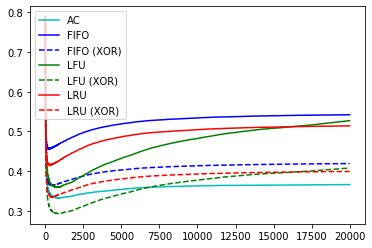

AC connection: 0.366341
FIFO connection: 0.542058
FIFO connection (XOR): 0.419192
LFU connection: 0.527194
LFU connection (XOR): 0.408001
LRU connection: 0.514027
LRU connection (XOR): 0.399445


In [3]:
M = 1
N = 20000
test_N = 2000
num_of_video = 100
num_of_client = 50
cache_size = 20
zipf_param = 1
s_len = 10
l_len = 100
K = 10
ch_p = 0.001
rho = 0.5

AC_con,AC_tcon,FIFO_con,FIFO_xcon,FIFO_tcon,FIFO_txcon,LFU_con,LFU_xcon,LFU_tcon,LFU_txcon,LRU_con,LRU_xcon,LRU_tcon,LRU_txcon = Comp(
    M, N, num_of_video, num_of_client, cache_size, s_len, l_len, K, zipf_param)

t = [n for n in range(N)]

plt.plot(t,AC_con,'c')
plt.plot(t,FIFO_con,'b')
plt.plot(t,FIFO_xcon,'b--')
plt.plot(t,LFU_con,'g')
plt.plot(t,LFU_xcon,'g--')
plt.plot(t,LRU_con,'r')
plt.plot(t,LRU_xcon,'r--')
plt.legend(['AC', 'FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)'])
plt.show()

print('AC connection:', AC_con[N-1])
print('FIFO connection:', FIFO_con[N-1])
print('FIFO connection (XOR):', FIFO_xcon[N-1])
print('LFU connection:', LFU_con[N-1])
print('LFU connection (XOR):', LFU_xcon[N-1])
print('LRU connection:', LRU_con[N-1])
print('LRU connection (XOR):', LRU_xcon[N-1])

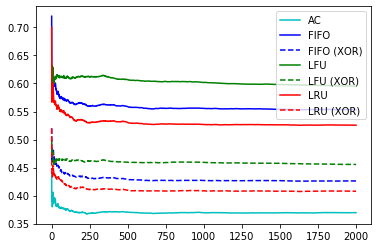

AC connection: 0.36947
FIFO connection: 0.55338
FIFO connection (XOR): 0.426
LFU connection: 0.59531
LFU connection (XOR): 0.45545
LRU connection: 0.52548
LRU connection (XOR): 0.40774


In [4]:
t = [n for n in range(test_N)]

plt.plot(t,AC_tcon,'c')
plt.plot(t,FIFO_tcon,'b')
plt.plot(t,FIFO_txcon,'b--')
plt.plot(t,LFU_tcon,'g')
plt.plot(t,LFU_txcon,'g--')
plt.plot(t,LRU_tcon,'r')
plt.plot(t,LRU_txcon,'r--')
plt.legend(['AC', 'FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)'])
plt.show()

print('AC connection:', AC_tcon[test_N-1])
print('FIFO connection:', FIFO_tcon[test_N-1])
print('FIFO connection (XOR):', FIFO_txcon[test_N-1])
print('LFU connection:', LFU_tcon[test_N-1])
print('LFU connection (XOR):', LFU_txcon[test_N-1])
print('LRU connection:', LRU_tcon[test_N-1])
print('LRU connection (XOR):', LRU_txcon[test_N-1])

# by rho

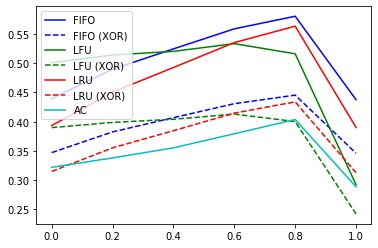

In [5]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

rho_list = [i*0.2 for i in range(6)]

for rho in rho_list:
    AC_con,AC_tcon,FIFO_con,FIFO_xcon,FIFO_tcon,FIFO_txcon,LFU_con,LFU_xcon,LFU_tcon,LFU_txcon,LRU_con,LRU_xcon,LRU_tcon,LRU_txcon = Comp(
    M, N, num_of_video, num_of_client, cache_size, s_len, l_len, K, zipf_param)
    
    FIFO_connection_list.append(FIFO_con[N-1])
    FIFO_Xconnection_list.append(FIFO_xcon[N-1])
    LFU_connection_list.append(LFU_con[N-1])
    LFU_Xconnection_list.append(LFU_xcon[N-1])
    LRU_connection_list.append(LRU_con[N-1])
    LRU_Xconnection_list.append(LRU_xcon[N-1])
    RL_connection_list.append(AC_con[N-1])
    
    FIFO_test_list.append(FIFO_tcon[test_N-1])
    FIFO_Xtest_list.append(FIFO_txcon[test_N-1])
    LFU_test_list.append(LFU_tcon[test_N-1])
    LFU_Xtest_list.append(LFU_txcon[test_N-1])
    LRU_test_list.append(LRU_tcon[test_N-1])
    LRU_Xtest_list.append(LRU_txcon[test_N-1])
    RL_test_list.append(AC_tcon[test_N-1])

plt.plot(rho_list,FIFO_connection_list,'b')
plt.plot(rho_list,FIFO_Xconnection_list,'b--')
plt.plot(rho_list,LFU_connection_list,'g')
plt.plot(rho_list,LFU_Xconnection_list,'g--')
plt.plot(rho_list,LRU_connection_list,'r')
plt.plot(rho_list,LRU_Xconnection_list,'r--')
plt.plot(rho_list,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'AC'])
plt.show()

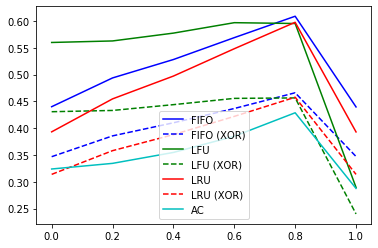

rho = [0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]
FIFO = [0.44002, 0.49366, 0.52797, 0.56877, 0.60866, 0.43959]
FIFOX = [0.34683, 0.38561, 0.41002, 0.43667, 0.466, 0.34715]
LFU = [0.55977, 0.56261, 0.57721, 0.59666, 0.59512, 0.2896]
LFUX = [0.43067, 0.43304, 0.44384, 0.45553, 0.45639, 0.24014]
LRU = [0.39316, 0.4546, 0.49713, 0.5481, 0.5974, 0.39299]
LRUX = [0.31387, 0.35807, 0.38794, 0.42195, 0.45768, 0.31384]
AC = [0.32389, 0.33438, 0.35474, 0.38491, 0.42869, 0.28769]


In [6]:
plt.plot(rho_list,FIFO_test_list,'b')
plt.plot(rho_list,FIFO_Xtest_list,'b--')
plt.plot(rho_list,LFU_test_list,'g')
plt.plot(rho_list,LFU_Xtest_list,'g--')
plt.plot(rho_list,LRU_test_list,'r')
plt.plot(rho_list,LRU_Xtest_list,'r--')
plt.plot(rho_list,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'AC'])
plt.show()

print('rho =', rho_list)
print('FIFO =', FIFO_test_list)
print('FIFOX =', FIFO_Xtest_list)
print('LFU =', LFU_test_list)
print('LFUX =', LFU_Xtest_list)
print('LRU =', LRU_test_list)
print('LRUX =', LRU_Xtest_list)
print('AC =', RL_test_list)

# by Cache Size

In [7]:
rho = 0.5

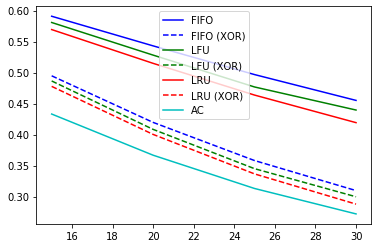

In [8]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

cache_sizes = [i*5 for i in range(3,7)]

for size in cache_sizes:
    AC_con,AC_tcon,FIFO_con,FIFO_xcon,FIFO_tcon,FIFO_txcon,LFU_con,LFU_xcon,LFU_tcon,LFU_txcon,LRU_con,LRU_xcon,LRU_tcon,LRU_txcon = Comp(
    M, N, num_of_video, num_of_client, size, s_len, l_len, K, zipf_param)
    
    FIFO_connection_list.append(FIFO_con[N-1])
    FIFO_Xconnection_list.append(FIFO_xcon[N-1])
    LFU_connection_list.append(LFU_con[N-1])
    LFU_Xconnection_list.append(LFU_xcon[N-1])
    LRU_connection_list.append(LRU_con[N-1])
    LRU_Xconnection_list.append(LRU_xcon[N-1])
    RL_connection_list.append(AC_con[N-1])
    
    FIFO_test_list.append(FIFO_tcon[test_N-1])
    FIFO_Xtest_list.append(FIFO_txcon[test_N-1])
    LFU_test_list.append(LFU_tcon[test_N-1])
    LFU_Xtest_list.append(LFU_txcon[test_N-1])
    LRU_test_list.append(LRU_tcon[test_N-1])
    LRU_Xtest_list.append(LRU_txcon[test_N-1])
    RL_test_list.append(AC_tcon[test_N-1])

plt.plot(cache_sizes,FIFO_connection_list,'b')
plt.plot(cache_sizes,FIFO_Xconnection_list,'b--')
plt.plot(cache_sizes,LFU_connection_list,'g')
plt.plot(cache_sizes,LFU_Xconnection_list,'g--')
plt.plot(cache_sizes,LRU_connection_list,'r')
plt.plot(cache_sizes,LRU_Xconnection_list,'r--')
plt.plot(cache_sizes,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'AC'])
plt.show()

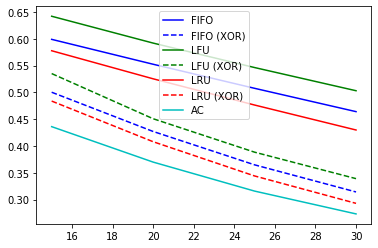

cache_size = [15, 20, 25, 30]
FIFO = [0.59892, 0.55246, 0.50754, 0.46401]
FIFOX = [0.50021, 0.427, 0.36472, 0.31411]
LFU = [0.64205, 0.59196, 0.5463, 0.50304]
LFUX = [0.53505, 0.45077, 0.38836, 0.33895]
LRU = [0.57767, 0.52529, 0.47634, 0.42974]
LRUX = [0.48373, 0.40787, 0.34397, 0.29284]
AC = [0.43599, 0.36984, 0.31572, 0.27312]


In [9]:
plt.plot(cache_sizes,FIFO_test_list,'b')
plt.plot(cache_sizes,FIFO_Xtest_list,'b--')
plt.plot(cache_sizes,LFU_test_list,'g')
plt.plot(cache_sizes,LFU_Xtest_list,'g--')
plt.plot(cache_sizes,LRU_test_list,'r')
plt.plot(cache_sizes,LRU_Xtest_list,'r--')
plt.plot(cache_sizes,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'AC'])
plt.show()

print('cache_size =', cache_sizes)
print('FIFO =', FIFO_test_list)
print('FIFOX =', FIFO_Xtest_list)
print('LFU =', LFU_test_list)
print('LFUX =', LFU_Xtest_list)
print('LRU =', LRU_test_list)
print('LRUX =', LRU_Xtest_list)
print('AC =', RL_test_list)

# by Number of Clients

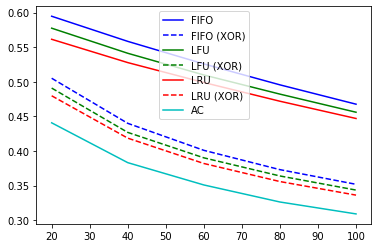

In [10]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

number_of_clients = [i*20 for i in range(1,6)]

for num in number_of_clients:
    AC_con,AC_tcon,FIFO_con,FIFO_xcon,FIFO_tcon,FIFO_txcon,LFU_con,LFU_xcon,LFU_tcon,LFU_txcon,LRU_con,LRU_xcon,LRU_tcon,LRU_txcon = Comp(
    M, N, num_of_video, num, cache_size, s_len, l_len, K, zipf_param)
    
    FIFO_connection_list.append(FIFO_con[N-1])
    FIFO_Xconnection_list.append(FIFO_xcon[N-1])
    LFU_connection_list.append(LFU_con[N-1])
    LFU_Xconnection_list.append(LFU_xcon[N-1])
    LRU_connection_list.append(LRU_con[N-1])
    LRU_Xconnection_list.append(LRU_xcon[N-1])
    RL_connection_list.append(AC_con[N-1])
    
    FIFO_test_list.append(FIFO_tcon[test_N-1])
    FIFO_Xtest_list.append(FIFO_txcon[test_N-1])
    LFU_test_list.append(LFU_tcon[test_N-1])
    LFU_Xtest_list.append(LFU_txcon[test_N-1])
    LRU_test_list.append(LRU_tcon[test_N-1])
    LRU_Xtest_list.append(LRU_txcon[test_N-1])
    RL_test_list.append(AC_tcon[test_N-1])

plt.plot(number_of_clients,FIFO_connection_list,'b')
plt.plot(number_of_clients,FIFO_Xconnection_list,'b--')
plt.plot(number_of_clients,LFU_connection_list,'g')
plt.plot(number_of_clients,LFU_Xconnection_list,'g--')
plt.plot(number_of_clients,LRU_connection_list,'r')
plt.plot(number_of_clients,LRU_Xconnection_list,'r--')
plt.plot(number_of_clients,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'AC'])
plt.show()

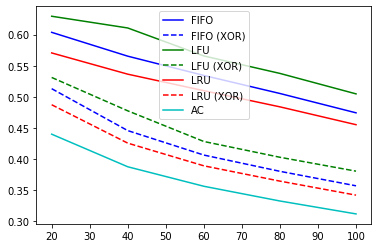

clients = [20, 40, 60, 80, 100]
FIFO = [0.6037, 0.565375, 0.5343916666666667, 0.5053875, 0.474305]
FIFOX = [0.513125, 0.4457125, 0.4064083333333333, 0.38025625, 0.35696]
LFU = [0.629575, 0.6107125, 0.5657333333333333, 0.5376625, 0.504765]
LFUX = [0.531175, 0.4775125, 0.428225, 0.40285, 0.380515]
LRU = [0.5706, 0.5364375, 0.5099, 0.48390625, 0.455235]
LRUX = [0.4873, 0.4255625, 0.3891, 0.3645, 0.34196]
AC = [0.439975, 0.387575, 0.3562416666666667, 0.33254375, 0.311785]


In [11]:
plt.plot(number_of_clients,FIFO_test_list,'b')
plt.plot(number_of_clients,FIFO_Xtest_list,'b--')
plt.plot(number_of_clients,LFU_test_list,'g')
plt.plot(number_of_clients,LFU_Xtest_list,'g--')
plt.plot(number_of_clients,LRU_test_list,'r')
plt.plot(number_of_clients,LRU_Xtest_list,'r--')
plt.plot(number_of_clients,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'AC'])
plt.show()

print('clients =', number_of_clients)
print('FIFO =', FIFO_test_list)
print('FIFOX =', FIFO_Xtest_list)
print('LFU =', LFU_test_list)
print('LFUX =', LFU_Xtest_list)
print('LRU =', LRU_test_list)
print('LRUX =', LRU_Xtest_list)
print('AC =', RL_test_list)

# by Number of Videos

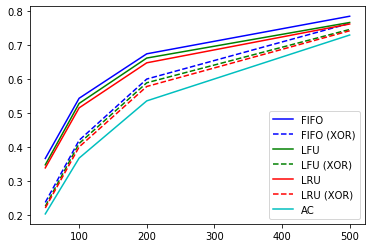

In [12]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

number_of_videos = [50, 100, 200, 500]

for num in number_of_videos:
    AC_con,AC_tcon,FIFO_con,FIFO_xcon,FIFO_tcon,FIFO_txcon,LFU_con,LFU_xcon,LFU_tcon,LFU_txcon,LRU_con,LRU_xcon,LRU_tcon,LRU_txcon = Comp(
    M, N, num, num_of_client, cache_size, s_len, l_len, K, zipf_param)
    
    FIFO_connection_list.append(FIFO_con[N-1])
    FIFO_Xconnection_list.append(FIFO_xcon[N-1])
    LFU_connection_list.append(LFU_con[N-1])
    LFU_Xconnection_list.append(LFU_xcon[N-1])
    LRU_connection_list.append(LRU_con[N-1])
    LRU_Xconnection_list.append(LRU_xcon[N-1])
    RL_connection_list.append(AC_con[N-1])
    
    FIFO_test_list.append(FIFO_tcon[test_N-1])
    FIFO_Xtest_list.append(FIFO_txcon[test_N-1])
    LFU_test_list.append(LFU_tcon[test_N-1])
    LFU_Xtest_list.append(LFU_txcon[test_N-1])
    LRU_test_list.append(LRU_tcon[test_N-1])
    LRU_Xtest_list.append(LRU_txcon[test_N-1])
    RL_test_list.append(AC_tcon[test_N-1])

plt.plot(number_of_videos,FIFO_connection_list,'b')
plt.plot(number_of_videos,FIFO_Xconnection_list,'b--')
plt.plot(number_of_videos,LFU_connection_list,'g')
plt.plot(number_of_videos,LFU_Xconnection_list,'g--')
plt.plot(number_of_videos,LRU_connection_list,'r')
plt.plot(number_of_videos,LRU_Xconnection_list,'r--')
plt.plot(number_of_videos,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'AC'])
plt.show()

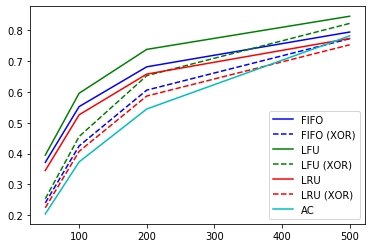

videos = [50, 100, 200, 500]
FIFO = [0.37159, 0.55234, 0.68141, 0.79417]
FIFOX = [0.2399, 0.42479, 0.60583, 0.77262]
LFU = [0.39497, 0.5957, 0.73791, 0.84537]
LFUX = [0.25362, 0.45525, 0.6527, 0.82213]
LRU = [0.34526, 0.52576, 0.65782, 0.77318]
LRUX = [0.22421, 0.40726, 0.58666, 0.75272]
AC = [0.20442, 0.37303, 0.54464, 0.78171]


In [13]:
plt.plot(number_of_videos,FIFO_test_list,'b')
plt.plot(number_of_videos,FIFO_Xtest_list,'b--')
plt.plot(number_of_videos,LFU_test_list,'g')
plt.plot(number_of_videos,LFU_Xtest_list,'g--')
plt.plot(number_of_videos,LRU_test_list,'r')
plt.plot(number_of_videos,LRU_Xtest_list,'r--')
plt.plot(number_of_videos,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'AC'])
plt.show()

print('videos =', number_of_videos)
print('FIFO =', FIFO_test_list)
print('FIFOX =', FIFO_Xtest_list)
print('LFU =', LFU_test_list)
print('LFUX =', LFU_Xtest_list)
print('LRU =', LRU_test_list)
print('LRUX =', LRU_Xtest_list)
print('AC =', RL_test_list)

# by zipf parameter

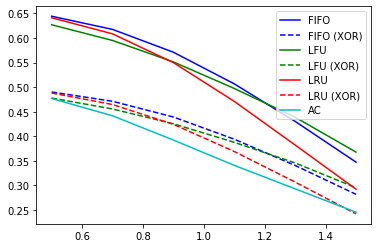

In [8]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

zipf_parameters = [0.5 + i*0.2 for i in range(6)]

for zipf in zipf_parameters:
    AC_con,AC_tcon,FIFO_con,FIFO_xcon,FIFO_tcon,FIFO_txcon,LFU_con,LFU_xcon,LFU_tcon,LFU_txcon,LRU_con,LRU_xcon,LRU_tcon,LRU_txcon = Comp(
    M, N, num_of_video, num_of_client, cache_size, s_len, l_len, K, zipf)
    
    FIFO_connection_list.append(FIFO_con[N-1])
    FIFO_Xconnection_list.append(FIFO_xcon[N-1])
    LFU_connection_list.append(LFU_con[N-1])
    LFU_Xconnection_list.append(LFU_xcon[N-1])
    LRU_connection_list.append(LRU_con[N-1])
    LRU_Xconnection_list.append(LRU_xcon[N-1])
    RL_connection_list.append(AC_con[N-1])
    
    FIFO_test_list.append(FIFO_tcon[test_N-1])
    FIFO_Xtest_list.append(FIFO_txcon[test_N-1])
    LFU_test_list.append(LFU_tcon[test_N-1])
    LFU_Xtest_list.append(LFU_txcon[test_N-1])
    LRU_test_list.append(LRU_tcon[test_N-1])
    LRU_Xtest_list.append(LRU_txcon[test_N-1])
    RL_test_list.append(AC_tcon[test_N-1])

plt.plot(zipf_parameters,FIFO_connection_list,'b')
plt.plot(zipf_parameters,FIFO_Xconnection_list,'b--')
plt.plot(zipf_parameters,LFU_connection_list,'g')
plt.plot(zipf_parameters,LFU_Xconnection_list,'g--')
plt.plot(zipf_parameters,LRU_connection_list,'r')
plt.plot(zipf_parameters,LRU_Xconnection_list,'r--')
plt.plot(zipf_parameters,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'AC'])
plt.show()

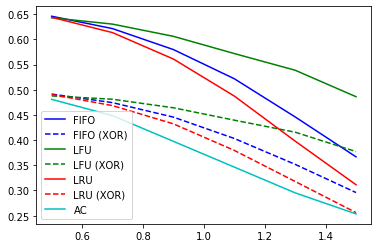

zipf_parameter = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
FIFO = [0.64594, 0.62138, 0.57977, 0.52187, 0.44604, 0.3668]
FIFOX = [0.49142, 0.47441, 0.44564, 0.40327, 0.35187, 0.29588]
LFU = [0.64298, 0.63029, 0.60605, 0.57188, 0.53874, 0.48619]
LFUX = [0.48779, 0.48112, 0.46421, 0.43961, 0.41573, 0.37724]
LRU = [0.64392, 0.61341, 0.56097, 0.48749, 0.39803, 0.31142]
LRUX = [0.49058, 0.46852, 0.43229, 0.37959, 0.3179, 0.25605]
AC = [0.48094, 0.44855, 0.39759, 0.34646, 0.2953, 0.25349]


In [9]:
plt.plot(zipf_parameters,FIFO_test_list,'b')
plt.plot(zipf_parameters,FIFO_Xtest_list,'b--')
plt.plot(zipf_parameters,LFU_test_list,'g')
plt.plot(zipf_parameters,LFU_Xtest_list,'g--')
plt.plot(zipf_parameters,LRU_test_list,'r')
plt.plot(zipf_parameters,LRU_Xtest_list,'r--')
plt.plot(zipf_parameters,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'AC'])
plt.show()

print('zipf_parameter =', zipf_parameters)
print('FIFO =', FIFO_test_list)
print('FIFOX =', FIFO_Xtest_list)
print('LFU =', LFU_test_list)
print('LFUX =', LFU_Xtest_list)
print('LRU =', LRU_test_list)
print('LRUX =', LRU_Xtest_list)
print('AC =', RL_test_list)